##### Preparations

In [1]:
# If on kaggle, copy the contents of the "../input/" directory to the cwd of kaggle
def copy_if_kaggle():
    import os
    import shutil

    if os.getcwd() == "/kaggle/working":
        # Set the source directory
        src_dir = os.path.join("../input", os.listdir("../input")[0])
        # Copy all files from the source directory to the current directory
        for file_name in os.listdir(src_dir):
            shutil.copy(os.path.join(src_dir, file_name), ".")


copy_if_kaggle()
# You can write up to 20GB to the cwd (/kaggle/working) that gets preserved as output when you push a version
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


In [2]:
# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectPercentile
from sklearn.svm import LinearSVC
from sklearn import set_config
set_config(transform_output="pandas")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
%matplotlib inline
import seaborn as sns
import plotly.io as pio
pio.templates.default = "plotly_dark"
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform
from statsmodels.stats.outliers_influence import variance_inflation_factor
import optuna
# Disable trail logging
# optuna.logging.set_verbosity(optuna.logging.WARNING)
import re

import warnings
warnings.filterwarnings('ignore')
import os
os.environ["PYTHONWARNINGS"] = "ignore"

# %%capture --no-stdout --no-display
# warnings.simplefilter("ignore")

In [3]:
# Plot styling
def my_dark_style():
    from cycler import cycler

    plt.style.use("default")
    plt.style.use(["dark_background", "bmh"])
    plt.rcParams["axes.facecolor"] = "#23272e"
    plt.rcParams["figure.facecolor"] = "#23272e"
    plt.rcParams["axes.prop_cycle"] = cycler(
        "color",
        [
            "#1c90d4",
            "#ad0026",
            "#530fff",
            "#429900",
            "#d55e00",
            "#ff47ac",
            "#42baff",
            "#009e73",
            "#fff133",
            "#0072b2",
        ],
    )
    # plt.rcParams['figure.figsize'] = 9, 7
    plt.rcParams["figure.autolayout"] = True


box_kws = dict(
    boxprops={"edgecolor": "#b2b2b2"},
    capprops={"color": "#b2b2b2"},
    flierprops={"markeredgecolor": "#b2b2b2"},
    medianprops={"color": "#b2b2b2"},
    whiskerprops={"color": "#b2b2b2"},
)
# # plt.rcParams['boxplot.boxprops.edgecolor'] = '#b2b2b2' no such rcParam
# plt.rcParams['boxplot.capprops.color'] = '#b2b2b2'
# plt.rcParams['boxplot.flierprops.markeredgecolor'] = '#b2b2b2'
# plt.rcParams['boxplot.medianprops.color'] = '#b2b2b2'
# plt.rcParams['boxplot.whiskerprops.color'] = '#b2b2b2'

my_dark_style()


In [4]:
# Load dataset
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")


def joint_data():
    return pd.concat([train_data, test_data])


all_data = joint_data()


# Store our passenger ID for easy access
PassengerId = test_data.pop("PassengerId")
train_data.drop(columns="PassengerId", inplace=True)

# Initializing random seed (integer) and/or state (instance)
# pass seed to CV splitters (KFold, RepeatedStratifiedKFold, etc.)
seed = 42
# pass rng to estimators and everything else;
# initialize a new rng for each estimator in order to prevent them from influencing each other by consuming the RNG
# rng = np.random.RandomState(seed)
# rng = np.random.default_rng(seed) # new numpy random Generator, not currently supported by sklearn

# If an integer is passed, calling fit or split multiple times always yields the same results.
# If a RandomState instance is passed: fit and split will yield different results each time they are called, and the succession of calls explores all sources of entropy.

### Overview

Nominal: `Survived, Sex, Embarked, Ticket`  
Ordinal: `Pclass`  
Continuous: `Age, Fare`  
Discrete: `SibSp, Parch` 

`Survived` - 0 = No, 1 = Yes  
`Pclass` is the ticket class - 1 = 1st, 2 = 2nd, 3 = 3rd  
`SibSp` is the number of siblings / the number of spouses aboard the Titanic  
`Parch` is the number of parents / the number children aboard the Titanic  
`Embarked` is the port of embarkation	- C = Cherbourg, Q = Queenstown, S = Southampton  

In [5]:
print(train_data.info())
train_data.sample(3)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB
None


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
67,0,3,"Crease, Mr. Ernest James",male,19.0,0,0,S.P. 3464,8.1583,NaN,S
334,1,1,"Frauenthal, Mrs. Henry William (Clara Heinshei...",female,NaN,1,0,PC 17611,133.6500,NaN,S
130,0,3,"Drazenoic, Mr. Jozef",male,33.0,0,0,349241,7.8958,NaN,C


In [6]:
print(test_data.info())
test_data.sample(3)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 32.8+ KB
None


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
50,1,"Smith, Mr. Lucien Philip",male,24.0,1,0,13695,60.00,C31,S
87,3,"Badman, Miss. Emily Louisa",female,18.0,0,0,A/4 31416,8.05,NaN,S
373,2,"Harbeck, Mr. William H",male,44.0,0,0,248746,13.00,NaN,S


In [7]:
train_data.describe(include="all")


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


### Exploratory Data Analysis and Data Cleaning

##### Basic visualizations

Passengers with first-class tickets had the highest survival rate, while those in third class had the lowest survival rate.

<Axes: xlabel='Pclass', ylabel='count'>

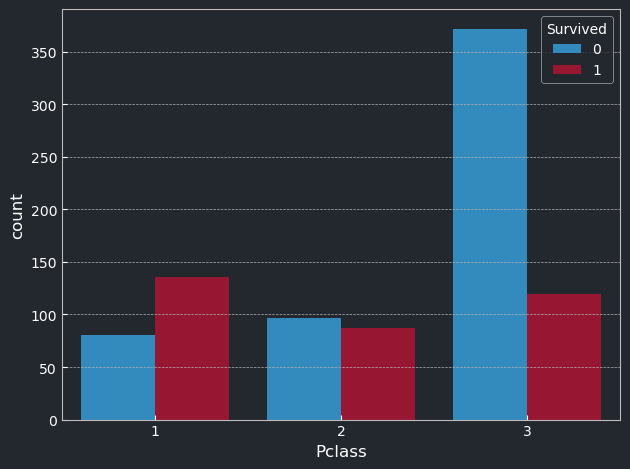

In [8]:
sns.countplot(train_data, x="Pclass", hue="Survived")


 The survival rate of females was significantly higher than that of men.

<Axes: xlabel='Sex', ylabel='count'>

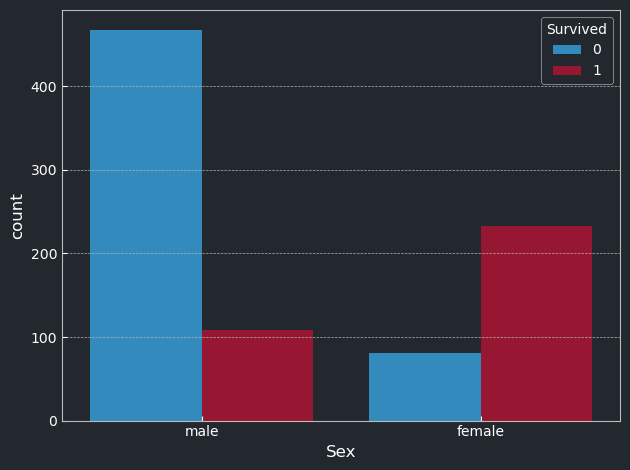

In [9]:
sns.countplot(train_data, x="Sex", hue="Survived")


 Passengers with no siblings/spouses/parents/children on board with them seem to have had a lower survival rate than those with a few companions.

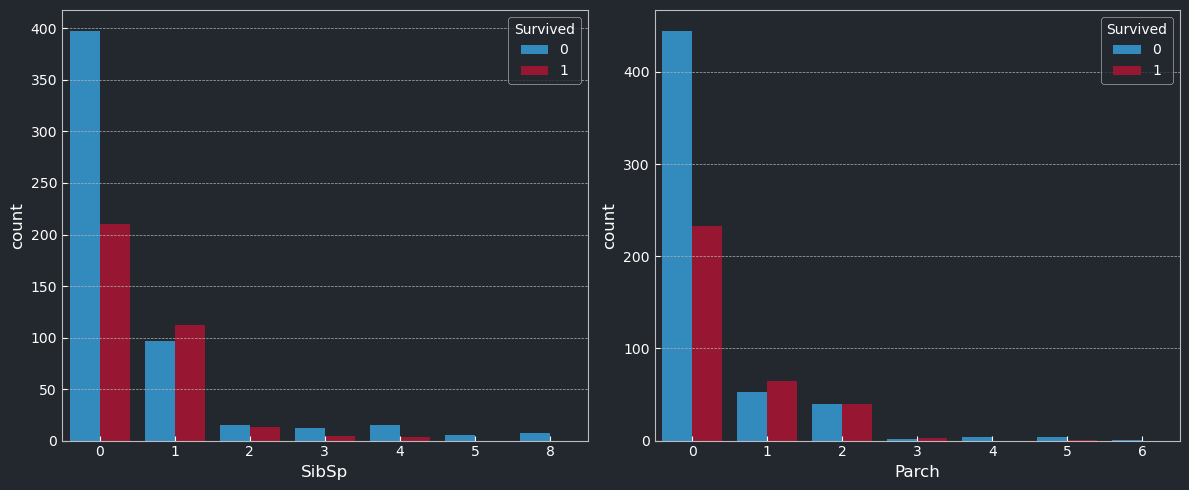

In [10]:
_, axs = plt.subplots(1, 2, figsize=(12, 5))
for ax, col in enumerate(["SibSp", "Parch"]):
    sns.countplot(train_data, x=col, hue="Survived", ax=axs[ax])


Those who embarked form the Southampton port had the lowest survival rate. Considering the numbers and order of embarkation (S->C->Q), it is also reasonable to assume that the majority of 3rd class passengers embarked form the Southampton port.

<Axes: xlabel='Embarked', ylabel='count'>

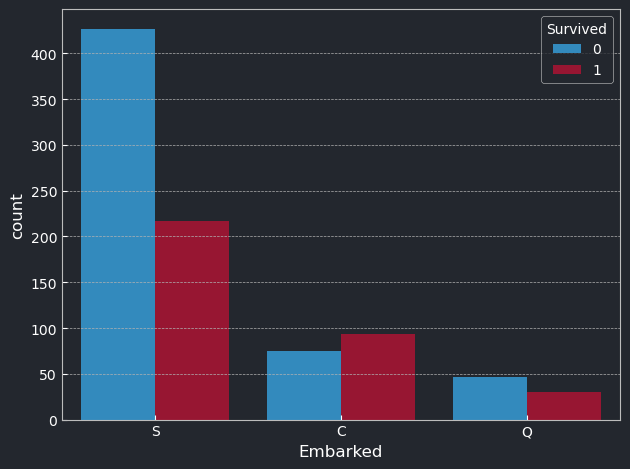

In [11]:
sns.countplot(train_data, x="Embarked", hue="Survived")


Children and elderly passengers had the highest survival rates, whereas those between the age of 20 and 30 had the lowest chance of surviving.

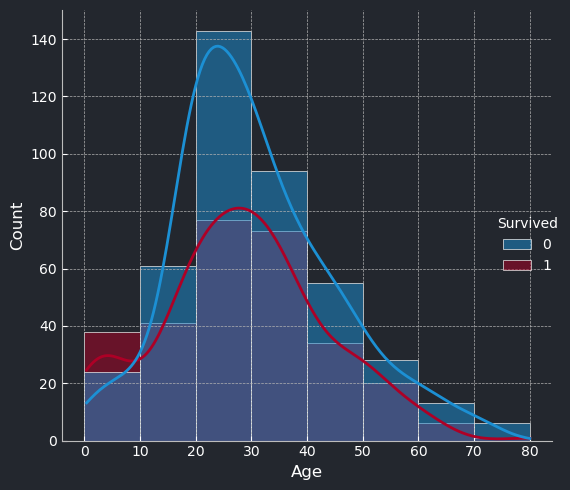

In [12]:
sns.displot(
    train_data, x="Age", hue="Survived", binwidth=10, binrange=(0, 80), kde=True
)


Those with the cheapest tickets had the lowest survival rate. The distribution is strongly skewed to the right. Most tickets costing below 10, and few cost above 100.

Text(0.5, 1.0, 'Log scale')

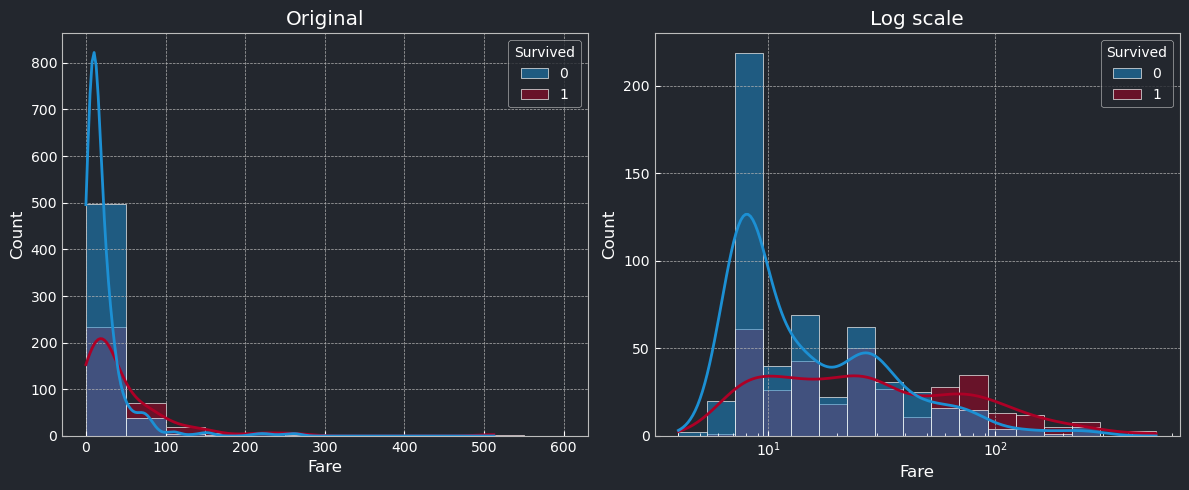

In [13]:
_, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(
    train_data,
    x="Fare",
    hue="Survived",
    binwidth=50,
    binrange=(0, 600),
    kde=True,
    ax=axs[0],
)
sns.histplot(
    train_data[train_data.Fare > 0],
    x="Fare",
    hue="Survived",
    log_scale=True,
    kde=True,
    ax=axs[1],
)
axs[0].set_title("Original")
axs[1].set_title("Log scale")


##### Missing values

There are missing values in the `Age, Fare, Cabin` and `Embarked` features. All imputation of missing values is done in a manner that avoids leakage, so some steps are included in a pipeline.

In [14]:
pd.DataFrame(
    [train_data.isna().sum(), test_data.isna().sum()], index=["Train", "Test"]
).T


,Train,Test
Survived,0.0,NaN
Pclass,0.0,0.0
Name,0.0,0.0
Sex,0.0,0.0
Age,177.0,86.0
SibSp,0.0,0.0
Parch,0.0,0.0
Ticket,0.0,0.0
Fare,0.0,1.0
Cabin,687.0,327.0


There is only one passenger with a missing `Fare` value. `Fare` is related to `Pclass`, `Embarked` and family size (`Parch` and `SibSp`) features. Median `Fare` value of a third class ticket with S as the port of embarkation for a passenger with no family is a logical choice to fill the missing value with.


In [15]:
test_data[test_data["Fare"].isna()]


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [16]:
# Blame black formatter for the lousy formatting..
test_data["Fare"].fillna(
    train_data.groupby(["Pclass", "Embarked", "Parch", "SibSp"]).Fare.mean()[3]["S"][0][
        0
    ],
    inplace=True,
)


There are only 2 missing values for `Embarked`. They are filled with the most frequent value.

In [17]:
train_data["Embarked"].fillna("S", inplace=True)


`Age` missing values are imputed using the median value grouped by `Pclass` and `Sex` (as they are likely indicators of age)

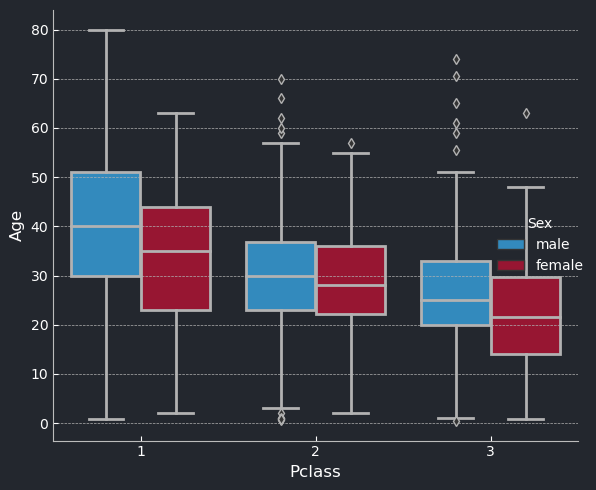

Sex     Pclass
female  1         35.0
        2         28.0
        3         21.5
male    1         40.0
        2         30.0
        3         25.0
Name: Age, dtype: float64

In [18]:
class AgeImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        sex_column = [col for col in X.columns if re.match(r"^Sex", col)][0]
        self.age_median_group = X.groupby([sex_column, "Pclass"])["Age"].median()
        return self

    def transform(self, X, y=None):
        sex_column = [col for col in X.columns if re.match(r"^Sex", col)][0]
        X = X.copy()
        X["Age"] = X.apply(
            lambda x: self.age_median_group[x[sex_column], x["Pclass"]]
            if pd.isna(x["Age"])
            else x["Age"],
            axis=1,
        )
        return X


# age_imputer is later included in the pipeline
age_imputer = AgeImputer()
sns.catplot(data=train_data, x="Pclass", y="Age", hue="Sex", kind="box", **box_kws)
plt.show()
age_imputer.fit(train_data).age_median_group


In [19]:
# `Age` missing values are imputed using the mean value from the nearest neighbors (using `Pclass` and `Sex` as features, as they are likely indicators of age)

In [20]:
# _, axs = plt.subplots(1, 4, figsize=(15, 5))
# for ax, col in enumerate(["Pclass", "Sex"]):
#     sns.boxplot(
#         train_data,
#         x=col,
#         y="Age",
#         ax=axs[ax],
#         # boxprops={"edgecolor": "#b2b2b2"},
#         # capprops={"color": "#b2b2b2"},
#         # flierprops={"markeredgecolor": "#b2b2b2"},
#         # medianprops={"color": "#b2b2b2"},
#         # whiskerprops={"color": "#b2b2b2"},
#         **box_kws
#     )


In [21]:
# train_data[age_na := train_data["Age"].isna()].head(3)


In [22]:
# neighbors = ["Age", "Pclass", "Sex"]
# # Encode `Sex`
# ord_enc = OneHotEncoder(drop="first", sparse_output=False)
# train_data["Sex"] = ord_enc.fit_transform(train_data[["Sex"]])
# test_data["Sex"] = ord_enc.transform(test_data[["Sex"]])
# # Scale
# ss = StandardScaler()
# train_data[neighbors] = ss.fit_transform(train_data[neighbors])
# test_data[neighbors] = ss.transform(test_data[neighbors])
# # Impute `Age`
# knn_imp = KNNImputer(n_neighbors=3, weights="distance")
# train_data[neighbors] = knn_imp.fit_transform(train_data[neighbors])
# test_data[neighbors] = knn_imp.transform(test_data[neighbors])
# # Temporarily format back to previous scale and decode `Sex` back to male/female for interpretability
# for data in [train_data, test_data]:
#     data[neighbors] = ss.inverse_transform(data[neighbors])
#     data[neighbors[1:]] = data[neighbors[1:]].round().astype(int)
#     data["Sex"] = ord_enc.inverse_transform(data[["Sex"]])
# # CV flag


In [23]:
# train_data[age_na].head(3)


There are far too many missing `Cabin` values to meaningfully impute them, however the feature can't be ignored because some of the cabins might have higher survival rates. Another point of interest is that some passengers had multiple cabins (all on the same deck). Those with several decks paid a significantly higher fare price. Some cabin codes are preceded by an F. It is difficult to determine what this means, but judging by the price, the F is not a separate cabin, so it is removed and treated as a single cabin due to the low number of records containing it.

In [24]:
joint_data()[
    joint_data()["Cabin"].map(lambda x: len(x.split()), na_action="ignore") > 1
].head(10)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,0.0,1,"Fortune, Mr. Charles Alexander",male,19.00,3,2,19950,263.0000,C23 C25 C27,S
75,0.0,3,"Moen, Mr. Sigurd Hansen",male,25.00,0,0,348123,7.6500,F G73,S
88,1.0,1,"Fortune, Miss. Mabel Helen",female,23.00,3,2,19950,263.0000,C23 C25 C27,S
97,1.0,1,"Greenfield, Mr. William Bertram",male,23.00,0,1,PC 17759,63.3583,D10 D12,C
118,0.0,1,"Baxter, Mr. Quigg Edmond",male,24.00,0,1,PC 17558,247.5208,B58 B60,C
128,1.0,3,"Peter, Miss. Anna",female,NaN,1,1,2668,22.3583,F E69,C
297,0.0,1,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S
299,1.0,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50.00,0,1,PC 17558,247.5208,B58 B60,C
305,1.0,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S
311,1.0,1,"Ryerson, Miss. Emily Borie",female,18.00,2,2,PC 17608,262.3750,B57 B59 B63 B66,C


In [25]:
# Remove F_ from cabin codes
for data in [train_data, test_data]:
    data.loc[:, "Cabin"] = data["Cabin"].map(
        (lambda x: x.replace("F ", "")), na_action="ignore"
    )


An extra feature `NCabins` is created which contains the cabin count per passenger.

In [26]:
for data in [train_data, test_data]:
    data.loc[:, "NCabins"] = data["Cabin"].map(
        (lambda x: len(x.split())), na_action="ignore"
    )
    data.NCabins.fillna(1, inplace=True)

joint_data().NCabins.value_counts()


1.0    1275
2.0      19
3.0      10
4.0       5
Name: NCabins, dtype: int64

Passengers with multiple cabins have a higher survival rate compared to those with only one cabin.

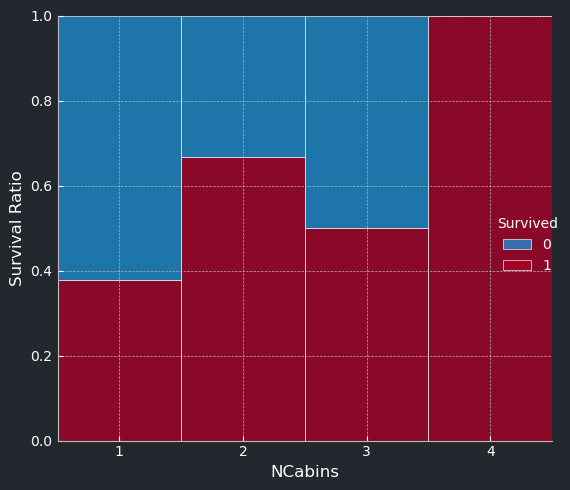

In [27]:
sns.displot(train_data, x="NCabins", hue="Survived", multiple="fill", discrete=True)
plt.ylabel("Survival Ratio")
plt.gca().xaxis.set_major_locator(mplticker.MultipleLocator(1))


In [28]:
# joint_data().groupby("Cabin", as_index=False).Ticket.nunique()[
#     joint_data()
#     .groupby("Cabin", as_index=False)
#     .Ticket.count()["Cabin"]
#     .map(lambda x: len(x.split()), na_action="ignore")
#     > 1
# ]


The first letter of each cabin code corresponds to the deck level where the cabin is located. `Deck` is extracted from the `Cabin` and the missing values simply encoded as "M". This way the missing values can be dealt with as a separate category of the `Deck` feature by the final model.

In [29]:
for data in [train_data, test_data]:
    data["Cabin"].fillna("M", inplace=True)
    data["Cabin"] = data.Cabin.apply(lambda x: x[0])
    data.rename(columns={"Cabin": "Deck"}, inplace=True)

joint_data().Deck.value_counts()


M    1014
C      94
B      65
D      46
E      44
A      22
F      14
G       9
T       1
Name: Deck, dtype: int64

# XXXXXXX ordinal or nominal?

`Deck` is an ordinal categorical feature. A is the topmost deck, G is the lowest passenger deck, T is the lowest deck of a ship (where the engines and boiler rooms are).  
Passengers on the middle decks B through F had the highest survival rates, whereas those on the lowest passenger deck, and those whose cabin codes are missing, had the lowest success rate. The only passenger whose cabin was on the Tank Top deck (below the Orlop Deck) did not survive.

Text(30.000000000000014, 0.5, 'Survival Ratio')

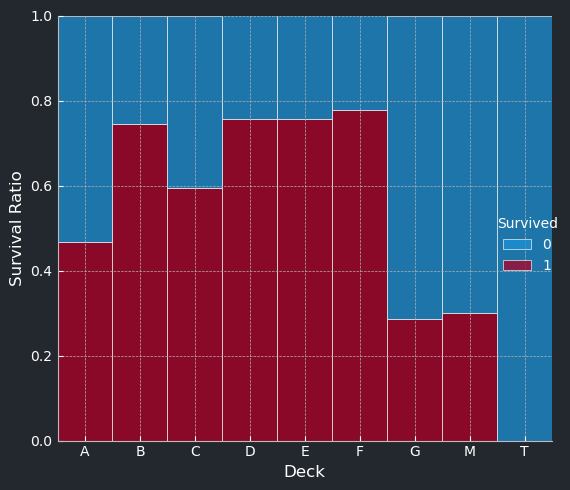

In [30]:
sns.displot(
    train_data.sort_values(by="Deck"), x="Deck", hue="Survived", multiple="fill"
)
plt.ylabel("Survival Ratio")


All missing values have been dealt with.

### Feature Engineering

`Family_Size` is created by adding `SibSp, Parch` and 1. Those who travel entirely alone don't seem to have had the highest chance of survival.

<Axes: xlabel='Family_Size', ylabel='count'>

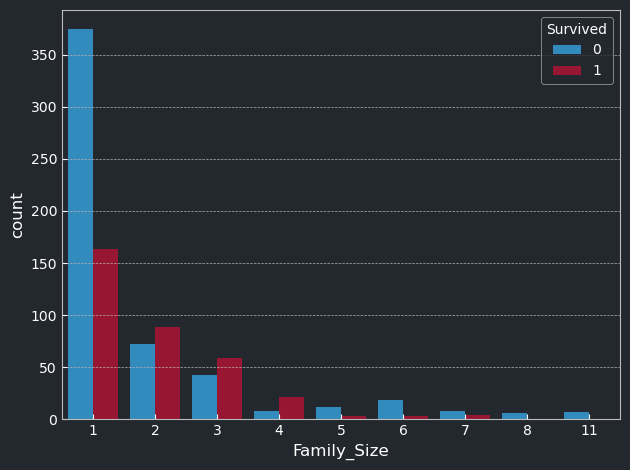

In [31]:
for data in [train_data, test_data]:
    data["Family_Size"] = data.SibSp + data.Parch + 1

sns.countplot(train_data, x="Family_Size", hue="Survived")


`Ticket_Freq` is created by encoding the frequency with which a ticket occurs, which gives an idea of the size of the group in which one was traveling.

<Axes: xlabel='Ticket_Freq', ylabel='count'>

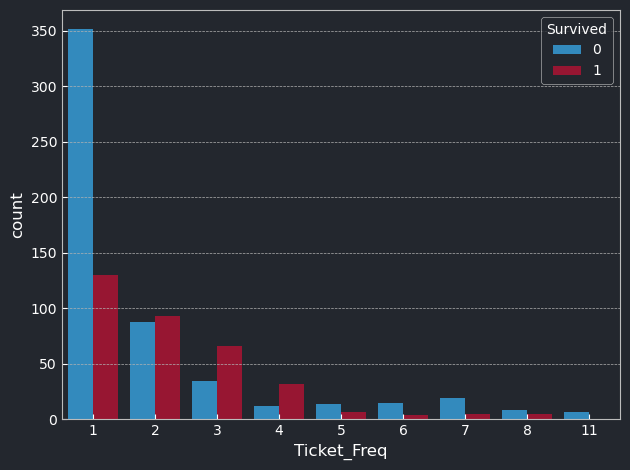

In [32]:
train_data["Ticket_Freq"] = (
    joint_data().groupby("Ticket")["Ticket"].transform("count")[:891]
)
test_data["Ticket_Freq"] = (
    joint_data().groupby("Ticket")["Ticket"].transform("count")[891:]
)

sns.countplot(train_data, x="Ticket_Freq", hue="Survived")


`Title` is extracted from the name. All titles with less than 10 samples are joined into a separate category 'Other'. Those with the title Mr. had the lowest survival rate. Mrs. had a higher survival rate than Miss.

In [33]:
for data in [train_data, test_data]:
    data["Title"] = (
        data["Name"].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    )
train_data.Title.value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64

In [34]:
train_data.loc[
    train_data.groupby("Title")["Title"].transform("size") < 10, "Title"
] = "Other"
test_data.loc[~test_data["Title"].isin(train_data["Title"]), "Title"] = "Other"
train_data.Title.value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Other      27
Name: Title, dtype: int64

<Axes: xlabel='Title', ylabel='count'>

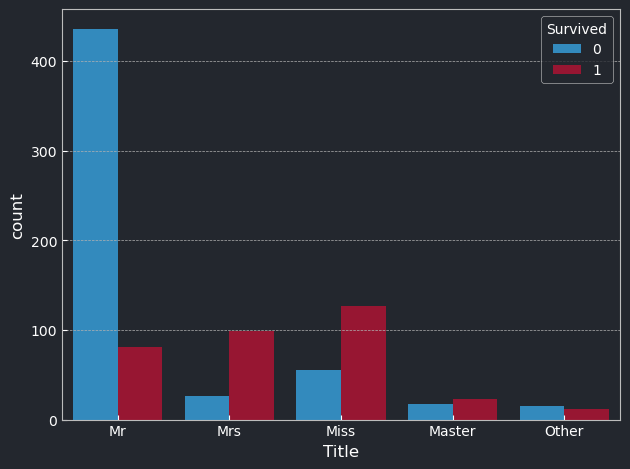

In [35]:
sns.countplot(train_data, x="Title", hue="Survived")

In [36]:
# def extract_surname(name):
#     if "(" in name:
#         name_no_bracket = name.split("(")[0]
#     else:
#         name_no_bracket = name
#     family = name_no_bracket.split(",")[0]
#     return family


# for data in [train_data, test_data]:
#     data["Name"] = data.Name.apply(extract_surname)

# train_data["Surname_Freq"] = (
#     joint_data().groupby("Name")["Name"].transform("count")[:891]
# )
# test_data["Surname_Freq"] = (
#     joint_data().groupby("Name")["Name"].transform("count")[891:]
# )

# sns.countplot(train_data, x="Surname_Freq", hue="Survived")


`Name` and `Ticket` are dropped as they are no longer needed and contain no useful information.

In [37]:
for data in [train_data, test_data]:
    data.drop(columns=["Name", "Ticket"], inplace=True)


It is worth noting, that some passengers have a `Fare` of 0. Ismay traveled on a complimentary ticket, as well as his servants (Fry and Harrison), Andrews and the Guarantee Group, and Reuchlin. Assuming that the rest of the passengers who hadn't paid for their tickets also received complimentary tickets, a separate 1/0 (True/False) feature `Complimentary` is created to indicate this.

In [38]:
joint_data()[joint_data().Fare == 0]


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Deck,Embarked,NCabins,Family_Size,Ticket_Freq,Title
179,0.0,3,male,36.0,0,0,0.0,M,S,1.0,1,4,Mr
263,0.0,1,male,40.0,0,0,0.0,B,S,1.0,1,1,Mr
271,1.0,3,male,25.0,0,0,0.0,M,S,1.0,1,4,Mr
277,0.0,2,male,NaN,0,0,0.0,M,S,1.0,1,3,Mr
302,0.0,3,male,19.0,0,0,0.0,M,S,1.0,1,4,Mr
413,0.0,2,male,NaN,0,0,0.0,M,S,1.0,1,3,Mr
466,0.0,2,male,NaN,0,0,0.0,M,S,1.0,1,3,Mr
481,0.0,2,male,NaN,0,0,0.0,M,S,1.0,1,1,Mr
597,0.0,3,male,49.0,0,0,0.0,M,S,1.0,1,4,Mr
633,0.0,1,male,NaN,0,0,0.0,M,S,1.0,1,1,Mr


In [39]:
for data in [train_data, test_data]:
    data["Complimentary"] = data.Fare.apply(lambda x: 1 if x == 0 else 0)

joint_data()[joint_data().Fare == 0].sample(3)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Deck,Embarked,NCabins,Family_Size,Ticket_Freq,Title,Complimentary
302,0.0,3,male,19.0,0,0,0.0,M,S,1.0,1,4,Mr,1
179,0.0,3,male,36.0,0,0,0.0,M,S,1.0,1,4,Mr,1
277,0.0,2,male,NaN,0,0,0.0,M,S,1.0,1,3,Mr,1


`Fare` is transformed to log scale to deal with right skewness.

In [40]:
train_data.Fare.sort_values().head(50)

271    0.0000
597    0.0000
302    0.0000
633    0.0000
277    0.0000
413    0.0000
674    0.0000
263    0.0000
466    0.0000
732    0.0000
179    0.0000
806    0.0000
481    0.0000
822    0.0000
815    0.0000
378    4.0125
872    5.0000
326    6.2375
843    6.4375
818    6.4500
371    6.4958
202    6.4958
654    6.7500
143    6.7500
411    6.8583
825    6.9500
129    6.9750
804    6.9750
477    7.0458
611    7.0500
884    7.0500
131    7.0500
465    7.0500
210    7.0500
363    7.0500
784    7.0500
721    7.0542
631    7.0542
243    7.1250
590    7.1250
433    7.1250
761    7.1250
127    7.1417
354    7.2250
553    7.2250
598    7.2250
522    7.2250
875    7.2250
661    7.2250
244    7.2250
Name: Fare, dtype: float64

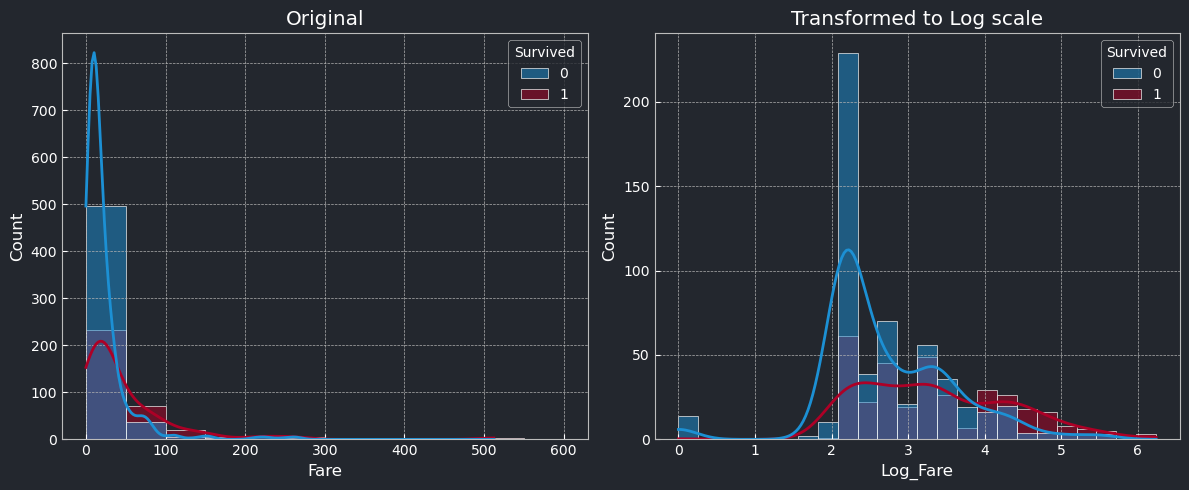

In [41]:
for data in [train_data, test_data]:
    data["Log_Fare"] = np.log1p(data["Fare"])

_, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(
    train_data,
    x="Fare",
    hue="Survived",
    binwidth=50,
    binrange=(0, 600),
    kde=True,
    ax=axs[0],
)
sns.histplot(
    train_data,
    x="Log_Fare",
    hue="Survived",
    kde=True,
    ax=axs[1],
)
axs[0].set_title("Original")
axs[1].set_title("Transformed to Log scale")

for data in [train_data, test_data]:
    data.drop(columns="Fare", inplace=True)


In [42]:
1 / (train_data.Log_Fare.sort_values().head(50) + 1)


271    1.000000
597    1.000000
302    1.000000
633    1.000000
277    1.000000
413    1.000000
674    1.000000
263    1.000000
466    1.000000
732    1.000000
179    1.000000
806    1.000000
481    1.000000
822    1.000000
815    1.000000
378    0.382858
872    0.358197
326    0.335652
843    0.332609
818    0.332423
371    0.331747
202    0.331747
654    0.328117
143    0.328117
411    0.326630
825    0.325397
129    0.325065
804    0.325065
477    0.324133
611    0.324079
884    0.324079
131    0.324079
465    0.324079
210    0.324079
363    0.324079
784    0.324079
721    0.324024
631    0.324024
243    0.323107
590    0.323107
433    0.323107
761    0.323107
127    0.322893
354    0.321835
553    0.321835
598    0.321835
522    0.321835
875    0.321835
661    0.321835
244    0.321835
Name: Log_Fare, dtype: float64

The ratio between the price and quantity could prove to be a useful feature, so it is created by dividing the `Log_Fare` by `Ticket_Freq`.

<Axes: xlabel='Log_Fare/Ticket_Freq', ylabel='Count'>

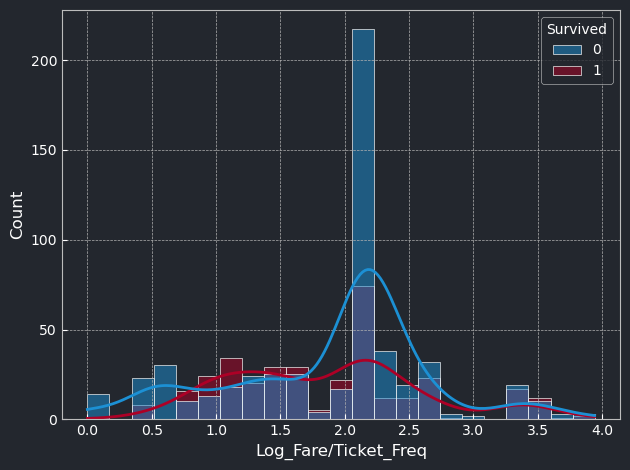

In [43]:
for data in [train_data, test_data]:
    data["Log_Fare/Ticket_Freq"] = data["Log_Fare"] / data["Ticket_Freq"]

sns.histplot(
    train_data,
    x="Log_Fare/Ticket_Freq",
    hue="Survived",
    kde=True,
)


##### Encoding

Nominal: `Survived, Sex, Deck, Embarked, Title, Complimentary`  
Ordinal: `Pclass`  
Continuous: `Age, Log_Fare, Log_Fare/Ticket_Freq`  
Discrete: `SibSp, Parch, NCabins, Family_Size, Ticket_Freq` 

In [44]:
# Might come in handy
nominal = ["Survived", "Sex", "Deck", "Embarked", "Title", "Complimentary"]
ordinal = ["Pclass"]
continuous = ["Age", "Log_Fare", "Log_Fare/Ticket_Freq"]
discrete = ["SibSp", "Parch", "NCabins", "Family_Size", "Ticket_Freq"]


In [45]:
joint_data().head()


,Survived,Pclass,Sex,Age,SibSp,Parch,Deck,Embarked,NCabins,Family_Size,Ticket_Freq,Title,Complimentary,Log_Fare,Log_Fare/Ticket_Freq
0,0.0,3,male,22.0,1,0,M,S,1.0,2,1,Mr,0,2.110213,2.110213
1,1.0,1,female,38.0,1,0,C,C,1.0,2,2,Mrs,0,4.280593,2.140297
2,1.0,3,female,26.0,0,0,M,S,1.0,1,1,Miss,0,2.188856,2.188856
3,1.0,1,female,35.0,1,0,C,S,1.0,2,2,Mrs,0,3.990834,1.995417
4,0.0,3,male,35.0,0,0,M,S,1.0,1,1,Mr,0,2.202765,2.202765


All features except `Sex, Deck, Embarked` and `Title` are already properly encoded, so only they are encoded (as a one-hot numeric array). Dummy variables include redundant information, so to overcome the Dummy variable Trap, one dummy per categorical variable is dropped. The choice of which dummy variable to drop is arbitrary and doesn't affect the model's overall performance, so the first is dropped automatically by OneHotEncoder. 

In [46]:
feat = ["Sex", "Deck", "Embarked", "Title"]
ohe = OneHotEncoder(drop="first", sparse_output=False)
train_data = train_data.drop(columns=feat).join(ohe.fit_transform(train_data[feat]))
test_data = test_data.drop(columns=feat).join(ohe.transform(test_data[feat]))
# for data in [train_data, test_data]:
#     data.drop(columns=["Deck_T", "Embarked_Q"], inplace=True)

joint_data().info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Survived              891 non-null    float64
 1   Pclass                1309 non-null   int64  
 2   Age                   1046 non-null   float64
 3   SibSp                 1309 non-null   int64  
 4   Parch                 1309 non-null   int64  
 5   NCabins               1309 non-null   float64
 6   Family_Size           1309 non-null   int64  
 7   Ticket_Freq           1309 non-null   int64  
 8   Complimentary         1309 non-null   int64  
 9   Log_Fare              1309 non-null   float64
 10  Log_Fare/Ticket_Freq  1309 non-null   float64
 11  Sex_male              1309 non-null   float64
 12  Deck_B                1309 non-null   float64
 13  Deck_C                1309 non-null   float64
 14  Deck_D                1309 non-null   float64
 15  Deck_E                

##### Dealing with Multicollinearity

In [47]:
class SelectCorrelationClusters(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        threshold=0.7,
        corr_method="spearman",
        linkage_method="ward",
        optimal_ordering=True,
    ):
        self.threshold = threshold
        self.corr_method = corr_method
        self.linkage_method = linkage_method
        self.optimal_ordering = optimal_ordering

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        # Remove constant columns and calculate correlation
        self.constant_cols = np.where(X.nunique() == 1)[0]
        self.corr_ = X.drop(columns=X.columns[self.constant_cols]).corr(
            method=self.corr_method
        )
        # Convert the correlation matrix to a distance matrix before performing hierarchical clustering
        distance_matrix = 1 - self.corr_.abs()
        self.Z = linkage(
            squareform(distance_matrix, checks=False),
            "ward",
            optimal_ordering=self.optimal_ordering,
        )
        # Extract the cluster labels for each feature based on the specified threshold
        clusters = fcluster(self.Z, self.threshold, criterion="distance")
        # Filter out highly correlated features
        # Keep one feature per cluster with the maximum average correlation
        self.kept_features = []
        for cluster_id in set(clusters):
            clusters_boolean = clusters == cluster_id
            corr_vals = self.corr_.iloc[clusters_boolean, clusters_boolean]
            best_feature_idx = corr_vals.abs().sum(axis=1).idxmax()
            self.kept_features.append(corr_vals.columns.get_loc(best_feature_idx))
        return self

    def transform(self, X, y=None):
        X = pd.DataFrame(X)
        return X.drop(columns=X.columns[self.constant_cols]).iloc[:, self.kept_features]

    def plot(self, annot=True, cmap="RdBu", split=True):
        if not split:
            # Plot clustermap
            sns.clustermap(
                self.corr_.round(2),
                row_linkage=self.Z,
                col_linkage=self.Z,
                cmap=cmap,
                annot=annot,
                annot_kws={"size": 8},
                vmin=-1,
                vmax=1,
                figsize=(15, 12),
                dendrogram_ratio=0.2,
            )
        else:
            # Plot dendrogram with correlation heatmap
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 8))
            dendro = dendrogram(
                self.Z,
                labels=self.corr_.columns,
                ax=ax1,
                leaf_rotation=90,
            )
            order = dendro["leaves"]
            sns.heatmap(
                self.corr_.iloc[order, order],
                cmap=cmap,
                annot=annot,
                vmin=-1,
                vmax=1,
                # linewidths=0.01,
                # linecolor="#23272e",
                ax=ax2,
            )
            fig.tight_layout()
        plt.show()


def calculate_vif(X):
    # Add constant column
    # X = add_constant(X)
    X = X.assign(const=1)

    # Calculate VIF for each variable
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return vif


When a dummy variable that represents more than two categories has a high VIF, multicollinearity does not necessarily exist. The variables will always have high VIFs if there is a small portion of cases in the category, regardless of whether the categorical variables are correlated to other variables, so dummy encoded nominal variables are ignored.  
`Family_Size, SibSp` and `Parch` have an infinite VIF score and are perfectly multicollinear. They all have high correlation scores, along with `Ticket_Freq`. Considering their MI scores, `Family_Size` is kept and the rest are dropped, along with `Log_Fare`, which also has high correlation scores with those previously mentioned and with `Log_Fare/Ticket_Freq`, with the exception that it also has high correlation with `Pclass` (which the rest do not), which results in a higher VIF score than `Log_Fare/Ticket_Freq`.

In [48]:
# impd_age is needed to demonstrate how things work with imputed age values,
# which will actually be imputed later, during CV
impd_age = age_imputer.fit_transform(train_data)

,Variable,VIF
0,SibSp,inf
1,Parch,inf
2,NCabins,1.140542
3,Family_Size,inf
4,Ticket_Freq,7.018631
5,Age,1.352074
6,Log_Fare,3.780690
7,Log_Fare/Ticket_Freq,3.079046
8,Pclass,2.693121
9,const,0.000000


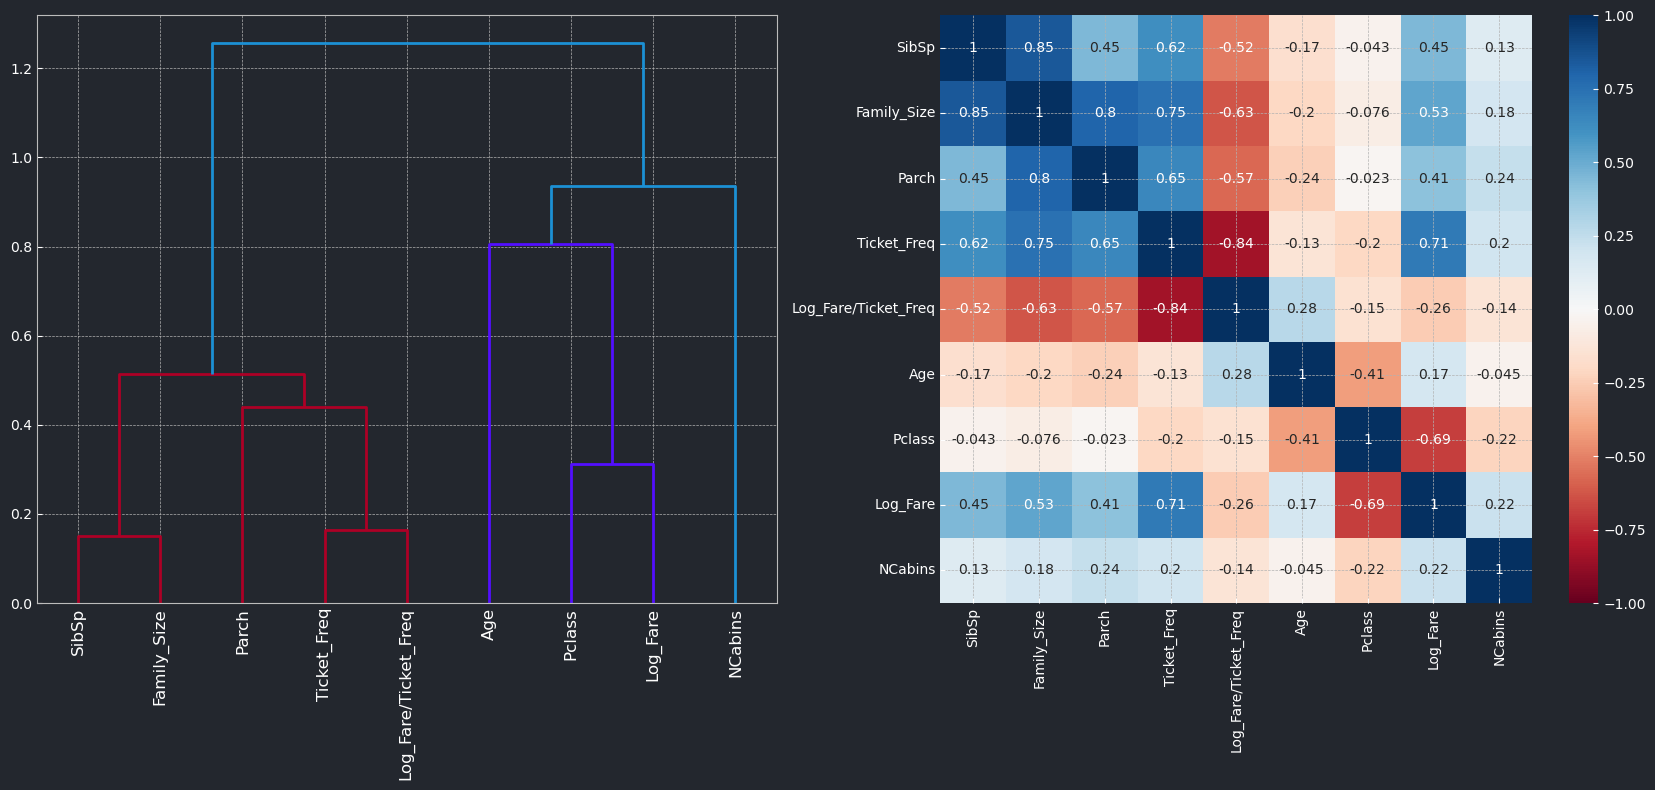

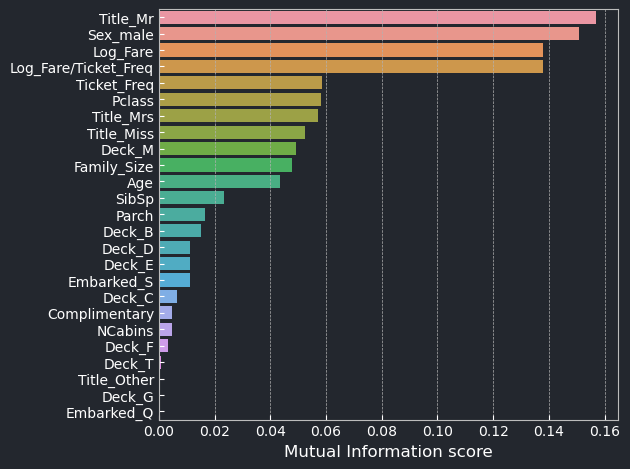

In [49]:
# %%capture --no-display
display(calculate_vif(impd_age[discrete + continuous + ordinal]))
SelectCorrelationClusters().fit(impd_age[discrete + continuous + ordinal]).plot()
mutinf = pd.Series(
    mutual_info_classif(
        impd_age.drop(columns="Survived"),
        train_data["Survived"],
        discrete_features=[
            True
            if col
            not in [
                "Age",
                "Log_Fare",
                "Log_Fare/Ticket_Freq",
            ]
            else False
            for col in train_data.drop(columns="Survived").columns
        ],
        # discrete_features=True,
        random_state=seed,
    ),
    index=train_data.drop(columns="Survived").columns,
).sort_values(ascending=False)
sns.barplot(x=mutinf, y=mutinf.index.astype(str))
plt.xlabel("Mutual Information score")
plt.tight_layout()
plt.show()

In [50]:
for data in [train_data, test_data]:
    data.drop(
        columns=[
            "SibSp",
            "Parch",
            "Ticket_Freq",
            "Log_Fare",
        ],
        inplace=True,
    )

# Might come in handy
nominal = ["Survived", "Sex", "Deck", "Embarked", "Title", "Complimentary"]
ordinal = ["Pclass"]
continuous = ["Age", "Log_Fare/Ticket_Freq"]
discrete = ["NCabins", "Family_Size"]

Now all VIF scores are within reasonable bounds.

In [51]:
calculate_vif(impd_age[discrete + continuous + ordinal])

,Variable,VIF
0,NCabins,1.106264
1,Family_Size,1.601887
2,Age,1.340466
3,Log_Fare/Ticket_Freq,1.715307
4,Pclass,1.322613
5,const,72.413026


##### Reciprocal

Next the multiplicative inverse of ordinal/continuous/discrete features is added.

In [52]:
class ReciprocalTransformer(BaseEstimator, TransformerMixin):
    def get_thresholds(self, column):
        # Find the minimum positive non-zero value (value closest to zero) in the column
        min_nonzero = np.min(column[column != 0].abs())
        # Calculate the closest 10^n value below the minimum non-zero value in the column
        self.threshold[column.name] = 10 ** np.floor(np.log10(min_nonzero))

    def transform_zeros(self, column):
        column_values = column.copy()
        # Find zero values in the column and replace them with the threshold value
        column_values.loc[column_values == 0] = self.threshold[column_values.name]
        return column_values

    def fit(self, X, y=None):
        # Store thresholds by column name
        self.threshold = {}
        # Exclude columns that are OHE dummies
        self.selected_columns = X.loc[
            :, ~np.all(np.logical_or(X == 0, X == 1), axis=0)
        ].columns
        # Get thresholds
        X[self.selected_columns].apply(self.get_thresholds)
        return self

    def transform(self, X, y=None):
        # Apply the transform_zeros function to each selected column
        transformed_columns = X[self.selected_columns].apply(self.transform_zeros)
        # Take the reciprocal of the transformed columns
        reciprocals = 1 / transformed_columns
        return X.join(reciprocals, rsuffix="_inverse")


ReciprocalTransformer().fit(train_data).transform(train_data).filter(
    regex="_inverse$"
).head()


,Pclass_inverse,Age_inverse,NCabins_inverse,Family_Size_inverse,Log_Fare/Ticket_Freq_inverse
0,0.333333,0.045455,1.0,0.5,0.473886
1,1.000000,0.026316,1.0,0.5,0.467225
2,0.333333,0.038462,1.0,1.0,0.456860
3,1.000000,0.028571,1.0,0.5,0.501148
4,0.333333,0.028571,1.0,1.0,0.453975


### Model training and selection

In [53]:
# Prepare data
X = train_data.copy()
y = X.pop("Survived")
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=seed, stratify=y
# )


In [54]:
# Define score function to go into SelectPercentile
discrete_features = [
    True
    if col
    not in [
        "Age",
        "Log_Fare/Ticket_Freq",
    ]
    else False
    for col in X.columns
]


def mut_info(X, y):
    return mutual_info_classif(
        X,
        y,
        discrete_features=discrete_features,
        random_state=seed,
    )


# Define transformer to clean up after adding feature interactions and standardizing
class RemoveDuplicates(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        df = pd.DataFrame(X)
        self.not_dup = list(df.columns[~df.T.duplicated()])
        return self

    def transform(self, X):
        df = pd.DataFrame(X)
        return df.loc[:, self.not_dup]  # .to_numpy()


# Define function to create a DataFrame from top scores
def get_top_scores(study, score_count=7):
    df = (
        study.trials_dataframe(attrs=("value", "duration", "params"))
        .sort_values(by="value", ascending=False)
        .head(score_count)
    ).rename(
        columns=lambda x: re.sub(r"^params_", "", x)
    )  # remove params_ from col names
    df["duration"] = df["duration"].dt.total_seconds()
    return df


# Define function to calculate validation/test scores for top sets of hyperparameters
def model_test_score(model, study_name, top_scores, results_storage):
    res = top_scores.value.to_list()
    for i in range(len(top_scores)):
        # Create dictionary of model parameters
        model_params = (
            top_scores.iloc[i]
            .drop(
                [
                    "value",
                    "duration",
                    "MI_percentile",
                    "selection_l1_C",
                    "l1_C",
                ]
            )
            .to_dict()
        )
        # Assign model parameters to estimator
        model.set_params(**model_params)
        # Create pipeline
        pipe = make_pipeline(
            age_imputer,
            SelectPercentile(mut_info, percentile=top_scores.iloc[i].MI_percentile),
            standardize,
            model,
        )
        # Update pipeline with extra steps if needed
        if top_scores.iloc[i].selection_l1_C:
            pipe.steps.insert(
                -1,
                (
                    "l1_selection",
                    SelectFromModel(
                        LinearSVC(
                            C=top_scores.iloc[i].l1_C,
                            penalty="l1",
                            dual=False,
                            max_iter=100000,
                            random_state=seed,
                        )
                    ),
                ),
            )
        # Get and store score results
        res.append(pipe.fit(X_train, y_train).score(X_test, y_test))
    # Add duration
    res.extend(top_scores.duration.to_list())
    # Assign results to proper index (model)
    results_storage.loc[study_name] = res
    # Format for display
    df = results_storage.loc[study_name].to_frame().reset_index()
    df[["col", "index"]] = df["index"].str.split("_", expand=True)
    df["index"] = df["index"].astype(int)
    df = df.pivot(index="index", columns="col")
    df.columns = df.columns.droplevel()
    df.columns.name, df.index.name = None, None
    column_order = ["cv", "test", "duration"]
    return df.reindex(column_order, axis=1)


# Define function to generate n top submissions
def submissions_from_model(
    model, study_name, top_scores, results_storage, n_submissions=3
):
    # Sort parameters by test scores
    scores_by_test = top_scores.copy()
    scores_by_test["sort"] = model_results.loc[study_name][
        len(scores_by_test) : len(scores_by_test) * 2
    ].to_numpy()
    scores_by_test.sort_values(by="sort", ascending=False, inplace=True)
    scores_by_test.drop(columns="sort", inplace=True)

    for i in range(n_submissions):
        # Create dictionary of model parameters
        model_params = (
            top_scores.iloc[i]
            .drop(
                [
                    "value",
                    "duration",
                    "MI_percentile",
                    "selection_l1_C",
                    "l1_C",
                ]
            )
            .to_dict()
        )
        # Assign model parameters to estimator
        model.set_params(**model_params)
        # Create pipeline
        pipe = make_pipeline(
            age_imputer,
            SelectPercentile(mut_info, percentile=top_scores.iloc[i].MI_percentile),
            standardize,
            model,
        )
        # Update pipeline with extra steps if needed
        if top_scores.iloc[i].selection_l1_C:
            pipe.steps.insert(
                -1,
                (
                    "l1_selection",
                    SelectFromModel(
                        LinearSVC(
                            C=top_scores.iloc[i].l1_C,
                            penalty="l1",
                            dual=False,
                            max_iter=100000,
                            random_state=seed,
                        )
                    ),
                ),
            )
        # Generate predictions
        predictions = pipe.fit(X, y).predict(test_data)
        # Create submission CSV
        predictions_df = pd.DataFrame(
            {"PassengerId": PassengerId, "Survived": predictions}
        )
        predictions_df.to_csv(
            f"{study_name}_submission_{i+1}.csv", header=True, index=False
        )

In [55]:
# Initialize pipeline steps
# inverse = ReciprocalTransformer()
standardize = StandardScaler()
cleanup = RemoveDuplicates()

# Define DB file name for storing tuning results
db_name = "titanic_study"
storage_name = f"sqlite:///{db_name}.db"

# Create DataFrame to store results of model evaluations
# score_count = 7
# score_count = 500
# model_results = pd.DataFrame(
#     columns=[f"cv_{i}" for i in range(1, score_count + 1)]
#     + [f"test_{i}" for i in range(1, score_count + 1)]
#     + [f"duration_{i}" for i in range(1, score_count + 1)]
# )
model_results = pd.DataFrame(
    columns=[
        "mean_nested_CV",
        "std_nested_CV",
        "mean_inner_CV",
        "std_inner_CV",
    ]
)
model_results.index.name = "Algorithm"

In [56]:
# Turn off optuna log notes.
optuna.logging.set_verbosity(optuna.logging.WARN)


# Define a function to output a log only when the best value is updated
def logging_callback(study, frozen_trial):
    previous_best_value = study.user_attrs.get("previous_best_value", None)
    if previous_best_value != study.best_value:
        study.set_user_attr("previous_best_value", study.best_value)
        print(
            "Trial {} finished with best value: {} and parameters: {}. ".format(
                frozen_trial.number,
                frozen_trial.value,
                frozen_trial.params,
            )
        )

In [57]:
# Define the objective of the study without the model
def cv_pipe(trial, model, X, y):
    # Create Pipeline
    pipe = make_pipeline(
        age_imputer,
        SelectPercentile(
            mut_info, percentile=trial.suggest_int("MI_percentile", 1, 100)
        ),
        standardize,
        model,
    )
    # if trial.suggest_categorical("selection_l1_C", [True, False]):
    #     pipe.steps.insert(
    #         -1,
    #         (
    #             "l1_selection",
    #             SelectFromModel(
    #                 LinearSVC(
    #                     C=trial.suggest_float("l1_C", 1e-2, 20, log=True),
    #                     penalty="l1",
    #                     dual=False,
    #                     max_iter=100000,
    #                     random_state=seed,
    #                 )
    #             ),
    #         ),
    #     )
    # Calculate scoring metric
    cv_score = cross_val_score(
        pipe,
        X,
        y,
        cv=RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=seed),
        n_jobs=-1,
    ).mean()
    return cv_score


In [58]:
def perform_nested_cv(
    objective,
    X,
    y,
    n_trials=100,
    study_timeout=120,
    n_splits=3,
    n_repeats=1,
    random_state=seed,
):
    print("Inner loop:\n")
    # Outer cross-validation
    cv_scores = []
    outer_scores = []
    outer_cv = RepeatedStratifiedKFold(
        n_splits=n_splits, n_repeats=n_repeats, random_state=random_state
    )
    split_n = 1
    for i, (train_index, test_index) in enumerate(outer_cv.split(X, y), 1):
        X_train_outer, X_test_outer = X.iloc[train_index], X.iloc[test_index]
        y_train_outer, y_test_outer = y.iloc[train_index], y.iloc[test_index]

        # Define unique identifier of the study
        study_name = f"{model.__class__.__name__}_split_{i}"
        study = optuna.create_study(
            storage=storage_name,
            study_name=study_name,
            sampler=optuna.samplers.TPESampler(
                multivariate=True, seed=seed, warn_independent_sampling=False
            ),
            direction="maximize",
            load_if_exists=True,
        )

        # Perform hyperparameter optimization (with inner cross-validation)
        study.optimize(
            lambda trial: objective(trial, X_train_outer, y_train_outer),
            n_trials=n_trials,
            timeout=study_timeout,
            # catch=(ValueError),
            # callbacks=[logging_callback],
        )
        cv_scores.append(study.best_value)
        print(f"    {study_name}")
        split_n += 1

        # Select and assign best hyperparameters
        best_study_params_ = study.best_params
        print(f"    Best params: {best_study_params_}")
        MI_percentile = best_study_params_.pop("MI_percentile")
        # Assign model parameters to estimator
        model.set_params(**best_study_params_)
        # Create pipeline
        pipe = make_pipeline(
            age_imputer,
            SelectPercentile(mut_info, percentile=MI_percentile),
            standardize,
            model,
        )

        # Refit the model with best hyperparameters on entire outer training data
        pipe.fit(X_train_outer, y_train_outer)

        # Evaluate on the outer test set
        score = pipe.score(X_test_outer, y_test_outer)
        outer_scores.append(score)
        print(
            f"    inner CV score: {study.best_value:.3f} | outer test score: {score:.3f}\n"
        )
    nest_mean, nest_std, inner_mean, inner_std = (
        np.mean(outer_scores),
        np.std(outer_scores),
        np.mean(cv_scores),
        np.std(cv_scores),
    )
    model_results.loc[model.__class__.__name__] = [
        nest_mean,
        nest_std,
        inner_mean,
        inner_std,
    ]
    print(
        f"Outer loop:\n\n    mean outer test score: {np.mean(outer_scores):.3f} +/- {np.std(outer_scores):.3f}"
    )
    # return outer_scores

##### Logistic Regression

In [59]:
rng = np.random.RandomState(seed)
# Initialize model
model = LogisticRegression(
    max_iter=100000,
    n_jobs=-1,
    random_state=rng,
)


# Define objective with the model
def objective_w_model(trial, X, y):
    # Set estimator parameters
    model.set_params(
        C=trial.suggest_float("C", 1e-4, 1000, log=True),
        solver=trial.suggest_categorical(
            "solver", ["liblinear", "lbfgs", "newton-cg", "sag", "saga"]
        ),
    )
    return cv_pipe(trial, model, X, y)


In [60]:
# # Define unique identifier of the study
# study_name = "Logistic_Regression"

# study = optuna.create_study(
#     storage=storage_name,
#     study_name=study_name,
#     sampler=optuna.samplers.TPESampler(
#         multivariate=True, seed=seed, warn_independent_sampling=False
#     ),
#     direction="maximize",
#     load_if_exists=True,
# )
# print(f"Sampler: {study.sampler.__class__.__name__}")

In [61]:
# # Perform hyperparameter optimization search
# study.optimize(
#     objective_w_model,
#     n_trials=5,
#     timeout=30,
#     # catch=(ValueError),
#     # callbacks=[logging_callback],
# )


In [62]:
# # Perform hyperparameter optimization search
# study.optimize(
#     objective_w_model,
#     n_trials=700,
#     timeout=3600,
#     catch=(ValueError),
#     # callbacks=[logging_callback],
# )


In [63]:
# Perform nested cross-validation
perform_nested_cv(objective_w_model, X, y)

Inner loop:

    LogisticRegression_split_1
    Best params: {'C': 5.462052089308381, 'MI_percentile': 99, 'solver': 'newton-cg'}
    inner CV score: 0.816 | outer test score: 0.838

    LogisticRegression_split_2
    Best params: {'C': 9.205825783430024, 'MI_percentile': 48, 'solver': 'newton-cg'}
    inner CV score: 0.820 | outer test score: 0.805

    LogisticRegression_split_3
    Best params: {'C': 255.25268658363873, 'MI_percentile': 98, 'solver': 'lbfgs'}
    inner CV score: 0.832 | outer test score: 0.835

Outer loop:

    mean outer test score: 0.826 +/- 0.015


##### K-Nearest Neighbours

In [64]:
rng = np.random.RandomState(seed)
# Initialize estimator
model = KNeighborsClassifier(
    n_jobs=-1,
)


# Define objective with the model
def objective_w_model(trial, X, y):
    # Set estimator parameters
    model.set_params(n_neighbors=trial.suggest_int("n_neighbors", 4, 40))
    return cv_pipe(trial, model, X, y)


In [65]:
# # Define unique identifier of the study
# study_name = "K-Nearest_Neighbors"

# study = optuna.create_study(
#     storage=storage_name,
#     study_name=study_name,
#     sampler=optuna.samplers.TPESampler(seed=seed),
#     direction="maximize",
#     load_if_exists=True,
# )
# print(f"Sampler: {study.sampler.__class__.__name__}")


In [66]:
# # Perform hyperparameter optimization search
# study.optimize(
#     objective_w_model,
#     n_trials=700,
#     timeout=3600,
#     catch=(ValueError),
#     # callbacks=[logging_callback],
# )


In [67]:
# Perform nested cross-validation
perform_nested_cv(objective_w_model, X, y)

Inner loop:

    KNeighborsClassifier_split_1
    Best params: {'MI_percentile': 43, 'n_neighbors': 10}
    inner CV score: 0.818 | outer test score: 0.825

    KNeighborsClassifier_split_2
    Best params: {'MI_percentile': 48, 'n_neighbors': 4}
    inner CV score: 0.818 | outer test score: 0.795

    KNeighborsClassifier_split_3
    Best params: {'MI_percentile': 40, 'n_neighbors': 7}
    inner CV score: 0.818 | outer test score: 0.818

Outer loop:

    mean outer test score: 0.813 +/- 0.013


##### Random Forest

In [68]:
rng = np.random.RandomState(seed)
# Initialize estimator
model = RandomForestClassifier(n_jobs=-1, random_state=rng)


# Define objective with the model
def objective_w_model(trial, X, y):
    # Set estimator parameters
    model.set_params(
        max_depth=trial.suggest_int("max_depth", 4, 20),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 5, 15),
        max_features=trial.suggest_float("max_features", 0.1, 0.5),
        ccp_alpha=trial.suggest_float("ccp_alpha", 1e-9, 0.3),
    )
    return cv_pipe(trial, model, X, y)

In [69]:
# # Define unique identifier of the study
# study_name = "Random_Forest"

# study = optuna.create_study(
#     storage=storage_name,
#     study_name=study_name,
#     sampler=optuna.samplers.TPESampler(seed=seed),
#     direction="maximize",
#     load_if_exists=True,
# )
# print(f"Sampler: {study.sampler.__class__.__name__}")


In [70]:
# # Perform hyperparameter optimization search
# study.optimize(
#     objective_w_model,
#     n_trials=700,
#     timeout=3600,
#     catch=(ValueError),
#     # callbacks=[logging_callback],
# )


In [71]:
# Perform nested cross-validation
perform_nested_cv(objective_w_model, X, y)

Inner loop:

    RandomForestClassifier_split_1
    Best params: {'MI_percentile': 44, 'ccp_alpha': 0.006244971109032087, 'max_depth': 13, 'max_features': 0.1521191495602566, 'min_samples_leaf': 13}
    inner CV score: 0.820 | outer test score: 0.822

    RandomForestClassifier_split_2
    Best params: {'MI_percentile': 51, 'ccp_alpha': 0.0009554097229149119, 'max_depth': 7, 'max_features': 0.2350368363565326, 'min_samples_leaf': 5}
    inner CV score: 0.829 | outer test score: 0.835

    RandomForestClassifier_split_3
    Best params: {'MI_percentile': 36, 'ccp_alpha': 0.003318089693682429, 'max_depth': 6, 'max_features': 0.20949643617346564, 'min_samples_leaf': 5}
    inner CV score: 0.828 | outer test score: 0.842

Outer loop:

    mean outer test score: 0.833 +/- 0.008


##### Support Vector Machine

In [72]:
rng = np.random.RandomState(seed)
# Initialize estimator
model = SVC(gamma="scale", max_iter=100000, random_state=rng, cache_size=1000)


# Define objective with the model
def objective_w_model(trial, X, y):
    # Set estimator parameters
    model.set_params(
        C=trial.suggest_float("C", 1e-4, 1000, log=True),
        kernel=trial.suggest_categorical("kernel", ["linear", "rbf", "sigmoid"]),
    )
    return cv_pipe(trial, model, X, y)

In [73]:
# # Define unique identifier of the study
# study_name = "Support Vector Machine"

# study = optuna.create_study(
#     storage=storage_name,
#     study_name=study_name,
#     sampler=optuna.samplers.TPESampler(seed=seed),
#     direction="maximize",
#     load_if_exists=True,
# )
# print(f"Sampler: {study.sampler.__class__.__name__}")


In [74]:
# # Perform hyperparameter optimization search
# study.optimize(
#     objective_w_model,
#     n_trials=700,
#     timeout=3600,
#     catch=(ValueError),
#     # callbacks=[logging_callback],
# )


In [75]:
# Perform nested cross-validation
perform_nested_cv(objective_w_model, X, y)

Inner loop:

    SVC_split_1
    Best params: {'C': 5.341885440298966, 'MI_percentile': 100, 'kernel': 'linear'}
    inner CV score: 0.822 | outer test score: 0.838

    SVC_split_2
    Best params: {'C': 1.0758515280659409, 'MI_percentile': 50, 'kernel': 'rbf'}
    inner CV score: 0.827 | outer test score: 0.818

    SVC_split_3
    Best params: {'C': 160.6483888531084, 'MI_percentile': 13, 'kernel': 'rbf'}
    inner CV score: 0.828 | outer test score: 0.835

Outer loop:

    mean outer test score: 0.831 +/- 0.009


##### AdaBoost

In [76]:
rng = np.random.RandomState(seed)
# Initialize estimator
model = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=rng)


# Define objective with the model
def objective_w_model(trial, X, y):
    # Set estimator parameters
    model.set_params(
        # estimator__max_depth=trial.suggest_int("estimator__max_depth", 1, 3),
        n_estimators=trial.suggest_int("n_estimators", 10, 100),
        learning_rate=trial.suggest_float("learning_rate", 1e-7, 1, log=True),
    )
    return cv_pipe(trial, model, X, y)

In [77]:
# # Define unique identifier of the study
# study_name = "AdaBoost"

# study = optuna.create_study(
#     storage=storage_name,
#     study_name=study_name,
#     sampler=optuna.samplers.TPESampler(seed=seed),
#     direction="maximize",
#     load_if_exists=True,
# )
# print(f"Sampler: {study.sampler.__class__.__name__}")


In [78]:
# # Perform hyperparameter optimization search
# study.optimize(
#     objective_w_model,
#     n_trials=700,
#     timeout=3600,
#     catch=(ValueError),
#     # callbacks=[logging_callback],
# )


In [79]:
# Perform nested cross-validation
perform_nested_cv(objective_w_model, X, y)

Inner loop:

    AdaBoostClassifier_split_1
    Best params: {'MI_percentile': 13, 'learning_rate': 0.961842338913892, 'n_estimators': 31}
    inner CV score: 0.802 | outer test score: 0.805

    AdaBoostClassifier_split_2
    Best params: {'MI_percentile': 36, 'learning_rate': 0.967544073076089, 'n_estimators': 91}
    inner CV score: 0.796 | outer test score: 0.768

    AdaBoostClassifier_split_3
    Best params: {'MI_percentile': 14, 'learning_rate': 0.03506535775283907, 'n_estimators': 90}
    inner CV score: 0.813 | outer test score: 0.798

Outer loop:

    mean outer test score: 0.790 +/- 0.016


##### Gradient Boosting

In [80]:
rng = np.random.RandomState(seed)
# Initialize estimator
model = GradientBoostingClassifier(
    random_state=rng,
)


# Define objective with the model
def objective_w_model(trial, X, y):
    # Set estimator parameters
    model.set_params(
        n_estimators=trial.suggest_int("n_estimators", 30, 400),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1, log=True),
        subsample=trial.suggest_float("subsample", 0.1, 1),
        min_samples_split=trial.suggest_float("min_samples_leaf", 1e-3, 1e-1, log=True),
        max_depth=trial.suggest_int("max_depth", 2, 30),
        max_features=trial.suggest_float("max_features", 0.1, 0.9),
        ccp_alpha=trial.suggest_float("ccp_alpha", 1e-9, 0.1),
    )
    return cv_pipe(trial, model, X, y)

In [81]:
# # Define unique identifier of the study
# study_name = "Gradient Boosting"

# study = optuna.create_study(
#     storage=storage_name,
#     study_name=study_name,
#     sampler=optuna.samplers.TPESampler(seed=seed),
#     direction="maximize",
#     load_if_exists=True,
# )
# print(f"Sampler: {study.sampler.__class__.__name__}")


In [82]:
# # Perform hyperparameter optimization search
# study.optimize(
#     objective_w_model,
#     n_trials=700,
#     timeout=3600,
#     catch=(ValueError),
#     # callbacks=[logging_callback],
# )


In [83]:
# Perform nested cross-validation
perform_nested_cv(objective_w_model, X, y)

Inner loop:

    GradientBoostingClassifier_split_1
    Best params: {'MI_percentile': 81, 'ccp_alpha': 0.0010154687841574341, 'learning_rate': 0.020442286948076857, 'max_depth': 19, 'max_features': 0.3068496519284849, 'min_samples_leaf': 0.03416534484051886, 'n_estimators': 172, 'subsample': 0.502924558172839}
    inner CV score: 0.823 | outer test score: 0.832

    GradientBoostingClassifier_split_2
    Best params: {'MI_percentile': 85, 'ccp_alpha': 0.001027570284055219, 'learning_rate': 0.0847067192763765, 'max_depth': 13, 'max_features': 0.23796886439329326, 'min_samples_leaf': 0.010352495148713715, 'n_estimators': 120, 'subsample': 0.5144310690397127}
    inner CV score: 0.832 | outer test score: 0.822

    GradientBoostingClassifier_split_3
    Best params: {'MI_percentile': 98, 'ccp_alpha': 0.004072440861458457, 'learning_rate': 0.07963685658760851, 'max_depth': 12, 'max_features': 0.31792877101644645, 'min_samples_leaf': 0.014473314099560389, 'n_estimators': 196, 'subsample': 

##### XGBoost

In [84]:
rng = np.random.RandomState(seed)
# Initialize estimator
model = XGBClassifier(booster="gbtree", random_state=rng, verbosity=0)


# Define objective with the model
def objective_w_model(trial, X, y):
    # Set estimator parameters
    model.set_params(
        n_estimators=trial.suggest_int("n_estimators", 50, 400),
        eta=trial.suggest_float("eta", 1e-3, 1, log=True),
        subsample=trial.suggest_float("subsmaple", 0.5, 1),
        max_depth=trial.suggest_int("max_depth", 6, 20),
        min_child_weight=trial.suggest_float("min_child_weight", 1e-3, 10, log=True),
        scale_pos_weight=trial.suggest_float(
            "scale_pos_weight", 0.56, 0.69
        ),  # (negative instances/positive instances) +/- 10%
        reg_alpha=trial.suggest_float("reg_alpha", 0, 10),
    )
    return cv_pipe(trial, model, X, y)

In [85]:
# # Define unique identifier of the study
# study_name = "XGBoost"

# study = optuna.create_study(
#     storage=storage_name,
#     study_name=study_name,
#     sampler=optuna.samplers.TPESampler(seed=seed),
#     direction="maximize",
#     load_if_exists=True,
# )
# print(f"Sampler: {study.sampler.__class__.__name__}")


In [86]:
# # Perform hyperparameter optimization search
# study.optimize(
#     objective_w_model,
#     n_trials=700,
#     timeout=3600,
#     catch=(ValueError),
#     # callbacks=[logging_callback],
# )


In [87]:
# Perform nested cross-validation
perform_nested_cv(objective_w_model, X, y)

Inner loop:

    XGBClassifier_split_1
    Best params: {'MI_percentile': 43, 'eta': 0.07620296270454825, 'max_depth': 15, 'min_child_weight': 0.003056938300145573, 'n_estimators': 305, 'reg_alpha': 1.3413132265578596, 'scale_pos_weight': 0.6418625363550059, 'subsmaple': 0.6383224111378512}
    inner CV score: 0.838 | outer test score: 0.835

    XGBClassifier_split_2
    Best params: {'MI_percentile': 81, 'eta': 0.023067460554363785, 'max_depth': 14, 'min_child_weight': 0.0021952197989826353, 'n_estimators': 198, 'reg_alpha': 1.2441535112551598, 'scale_pos_weight': 0.6642925268792821, 'subsmaple': 0.7661914098956175}
    inner CV score: 0.833 | outer test score: 0.822

    XGBClassifier_split_3
    Best params: {'MI_percentile': 53, 'eta': 0.013747468604597541, 'max_depth': 17, 'min_child_weight': 0.07204322631294871, 'n_estimators': 199, 'reg_alpha': 0.39064641375494014, 'scale_pos_weight': 0.6205960544655296, 'subsmaple': 0.8578658512344494}
    inner CV score: 0.838 | outer test sc

In [88]:
# model_results["mean_cv_score"] = model_results.filter(regex=r"^cv_").mean(axis=1)
# model_results["std_cv_score"] = model_results.filter(regex=r"^cv_").std(axis=1)
# model_results["mean_test_score"] = model_results.filter(regex=r"^test_").mean(axis=1)
# model_results["std_test_score"] = model_results.filter(regex=r"^test_").std(axis=1)
# model_results["mean_duration"] = model_results.filter(regex=r"^duration_").mean(axis=1)
# model_results.drop(
#     columns=model_results.filter(regex=r"^duration_").columns, inplace=True
# )
# model_results.sort_values(by="mean_test_score", ascending=False, inplace=True)


In [91]:
model_results.sort_values(by="mean_nested_CV", ascending=False)

,mean_nested_CV,std_nested_CV,mean_inner_CV,std_inner_CV
Algorithm,,,,
RandomForestClassifier,0.832772,0.008399,0.825758,4.180602e-03
SVC,0.830527,0.008837,0.825477,2.861403e-03
XGBClassifier,0.829405,0.005723,0.836700,2.380831e-03
LogisticRegression,0.826038,0.015141,0.822671,6.495980e-03
GradientBoostingClassifier,0.826038,0.004199,0.830808,5.625684e-03
KNeighborsClassifier,0.812570,0.012992,0.818182,1.281975e-16
AdaBoostClassifier,0.790123,0.016109,0.803872,6.975198e-03


In [90]:
break


SyntaxError: 'break' outside loop (668683560.py, line 1)

##### Fine-tuning final model

In [ ]:
class SelectFromPI:
    def __init__(self, percentile):
        self.percentile = percentile
        self.selector = SelectPercentile(
            score_func=self.permutation_importance_from_model,
            percentile=self.percentile,
        )

    @staticmethod
    def permutation_importance_from_model(X, y):
        model.fit(X, y)
        return permutation_importance(model, X, y, random_state=seed).importances_mean

    def fit(self, X, y):
        self.selector.fit(X, y)
        return self

    def transform(self, X):
        # Check if no features selected
        if self.selector.get_support().sum() == 0:
            # Select the best feature based on the provided score function
            best_feature_idx = self.selector.scores_.argmax()
            return pd.DataFrame(X).iloc[:, [best_feature_idx]]
        return self.selector.transform(X)


In [ ]:
# Define the objective of the study without the model
def cv_pipe(trial, model):
    # Create Pipeline
    pipe = make_pipeline(
        age_imputer,
        SelectPercentile(
            mut_info, percentile=trial.suggest_int("MI_percentile", 1, 100)
        ),
        standardize,
        cleanup,
        # SelectFromPI(percentile=trial.suggest_int("perm_perc", 0, 100)),
        # PCA(n_components=trial.suggest_float('PCA_components', 1e-2, 1)),  # float? variance explained is greater than percentage
        model,
    )
    if trial.suggest_categorical("reciprocal", [True, False]):
        pipe.steps.insert(
            2,
            (
                "reciprocal",
                inverse,
            ),
        )
    if trial.suggest_categorical("selection_l1_C", [True, False]):
        pipe.steps.insert(
            -1,
            (
                "l1_selection",
                SelectFromModel(
                    LinearSVC(
                        C=trial.suggest_float("l1_C", 1e-2, 20, log=True),
                        penalty="l1",
                        dual=False,
                        max_iter=100000,
                        random_state=seed,
                    )
                ),
            ),
        )
    # if trial.suggest_categorical("selection_EF_FI", [True, False]):
    #     pipe.steps.insert(
    #         -1,
    #         (
    #             "ET_selection",
    #             SelectFromModel(
    #                 ExtraTreesClassifier(
    #                     random_state=seed,
    #                 ),
    #                 threshold=f"{trial.suggest_float('ET_threshold', 1e-2, 1)}*mean",
    #             ),
    #         ),
    #     )
    # Calculate scoring metric
    cv_score = cross_val_score(
        pipe,
        X_train,
        y_train,
        cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed),
        n_jobs=-1,
    ).mean()
    return cv_score


##### Logistic Regression

In [ ]:
rng = np.random.RandomState(seed)
# Initialize model
model = LogisticRegression(
    max_iter=100000,
    n_jobs=-1,
    random_state=rng,
)


# Define objective with the model
def objective_w_model(trial, X, y):
    # Set estimator parameters
    model.set_params(
        C=trial.suggest_float("C", 1e-4, 1000, log=True),
        solver=trial.suggest_categorical(
            "solver", ["liblinear", "lbfgs", "newton-cg", "sag", "saga"]
        ),
    )
    return cv_pipe(trial, model, X, y)


In [ ]:
# Define unique identifier of the study
study_name = "Final_Model_XXX"

study = optuna.create_study(
    storage=storage_name,
    study_name=study_name,
    sampler=optuna.samplers.CmaEsSampler(with_margin=False, seed=seed),
    # sampler=optuna.samplers.TPESampler(multivariate=True, seed=seed),
    direction="maximize",
    load_if_exists=True,
)
print(f"Sampler: {study.sampler.__class__.__name__}")

In [ ]:
# Perform hyperparameter optimization search
study.optimize(
    objective_w_model,
    n_trials=30,
    timeout=300,
    catch=(ValueError),
    callbacks=[logging_callback],
)

In [ ]:
# # Perform hyperparameter optimization search
# study.optimize(
#     objective_w_model,
#     n_trials=3000,
#     timeout=21600,
#     catch=(ValueError),
#     callbacks=[logging_callback],
# )

In [ ]:
top_scores = get_top_scores(study)
top_scores


In [ ]:
model_test_score(model, study_name, top_scores, model_results)


In [ ]:
submissions_from_model(model, study_name, top_scores, model_results)


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
# optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
# optuna.visualization.plot_contour(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_edf(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

In [ ]:
break

In [ ]:
perm_rf = permutation_importance(
    rf_fit, X, y, random_state=seed, n_repeats=3, n_jobs=-1
)
perm_pipe = permutation_importance(
    pipe_fit, X, y, random_state=seed, n_repeats=3, n_jobs=-1
)


In [ ]:
perm_imp = (
    pd.DataFrame(perm_pipe.importances, index=X.columns)
    .reset_index()
    .melt(id_vars="index")
)


In [ ]:
sns.barplot(
    perm_imp,
    x="value",
    y="index",
    order=perm_imp.groupby("index")["value"].mean().sort_values(ascending=False).index,
)


In [ ]:
sns.barplot(
    x=perm_pipe.importances_mean,
    y=X.columns,
    order=[
        item[1]
        for item in sorted(zip(perm_pipe.importances_mean, X.columns), reverse=True)
    ],
)


In [ ]:
val_key = sorted(zip(randf.feature_importances_, randf.feature_names_in_), reverse=True)
val_key = pd.DataFrame(val_key)


In [ ]:
sns.barplot(x=val_key[0], y=val_key[1])


In [ ]:
val_key = sorted(zip(model.feature_importances_), reverse=True)
val_key = pd.DataFrame(val_key)


In [ ]:
# val_key


In [ ]:
sns.barplot(x=val_key[0], y=np.arange(val_key.shape[0]).astype(str))


In [ ]:
model.n_features_in_


Uncomment and run the following to open a real-time dashboard for Optuna (via your browser of choice) which contains detailed information about all trials for conveniently exploring the optimization history, hyperparameter importances, etc. in graphs and tables.

In [ ]:
# !optuna-dashboard sqlite:///titanic_study.db

Or execute the above command in a terminal (without the exclamation mark), and run the following cell to view the dashboard directly from within this notebook.

In [ ]:
# %%html
# <iframe src="http://127.0.0.1:8080/" width="1330" height="550"></iframe>

In [ ]:
top_scores = get_top_scores(study)
top_scores


In [ ]:
model_test_score(model, study_name, top_scores, model_results)


In [ ]:
submissions_from_model(model, study_name, top_scores, model_results)


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_edf(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)